In [1]:
import numpy as np
from modules.BS_MixG_model import C_MixG
from modules.BS_Theoretical_Model import BS_Theoretical_Value, add_noise_to_option_values
from matplotlib import pyplot as plt

In [2]:
# 设置随机数种子
np.random.seed(0)

In [3]:
n = 25
# 从1000-1700均匀取25个数
X = np.linspace(1000, 1700, n)
T = 30
r = 0.045
d = 0.025
ST = 1365
tau = T / 365
sigma_0 = 0.2
sigma_1000 = 0.2  # 当 X = 1000 时的波动率
sigma_1700 = 0.4  # 当 X = 1700 时的波动率

sigma_0

0.2

设置非参数模型优化问题

In [4]:
def loss(C_pred, C_true):
    if C_pred.shape != C_true.shape:
        raise ValueError("C_pred and C_true should have the same shape")
    return np.mean((C_pred - C_true) ** 2)

In [5]:
BS_Value = BS_Theoretical_Value(X, ST, T, r, d, sigma_1000, sigma_1700)
C_obs = add_noise_to_option_values(BS_Value, X)
# 优化参数
mu = np.random.uniform(low=7.107, high=7.265, size=(n + 1))
pi = np.ones(n + 1) / (n + 1)
C_pred = C_MixG(X, r, tau, sigma_0, mu, pi)
# 损失函数
print("Loss: ", loss(C_pred, C_obs))

Loss:  1077.699357205938


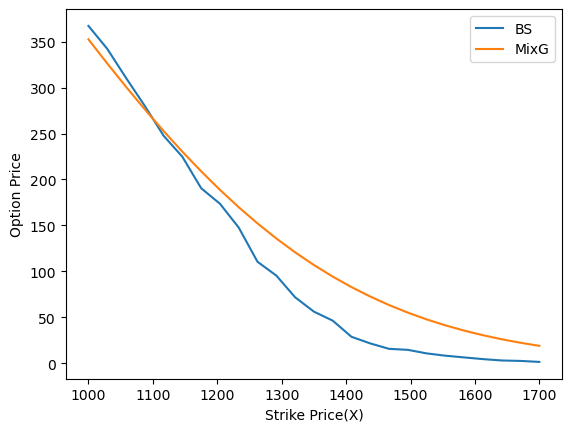

In [6]:
# 绘制图像BS和混合模型的对比
plt.plot(X, C_obs, label='BS')
plt.plot(X, C_pred, label='MixG')
plt.xlabel('Strike Price(X)')
plt.ylabel('Option Price')
plt.legend()
plt.show()

In [7]:
# 计算Expection价值
def Expection(mu, pi):
    return np.dot(np.exp(mu), pi) * np.exp(sigma_0 ** 2 / 2)

# 计算看涨期权下未来价值
def FutureValue(r, d, tau, X):
    return (np.exp((r - d) * tau) * X).mean()

FV = FutureValue(r, d, tau, X)
print("Expection: ", Expection(mu, pi))
print("Future Value: ", FV)

Expection:  1346.0498046161208
Future Value:  1352.2210030640301


进行对权重$\pi(·)$的二次优化

In [8]:
from scipy.optimize import minimize, LinearConstraint

# 目标函数
def objective(pi, X, r, tau, sigma_0, mu, C_obs):
    # C_pred 通过 C_MixG 计算
    C_pred = C_MixG(X, r, tau, sigma_0, mu, pi)
    return loss(C_pred, C_obs)


def constraint_expection(pi, mu):
    # 计算期望值和未来价值
    E_value = Expection(mu, pi)
    return E_value - FV

# 约束条件
cons = {'type': 'eq', 'fun': constraint_expection, 'args': (mu,)}
bounds = [(0, None)] * (n + 1)

# pi之和为1

pi_init = np.ones(n + 1) / (n + 1)  # 初始猜测的 pi

linear_constraint_1 = LinearConstraint(np.ones(n + 1), 1, 1)
res = minimize(objective, x0=pi_init, args=(X, r, tau, sigma_0, mu, C_obs), method='SLSQP', 
               constraints=[cons, linear_constraint_1], bounds=bounds,
               options={'disp': True, 'ftol': 1e-9})

pi_optimized = res.x
pi_optimized, pi

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1120.0083763330358
            Iterations: 7
            Function evaluations: 81
            Gradient evaluations: 3


(array([7.66920134e-13, 0.00000000e+00, 0.00000000e+00, 9.93005447e-01,
        0.00000000e+00, 0.00000000e+00, 1.05016638e-12, 0.00000000e+00,
        6.99455267e-03, 4.83700863e-12, 5.78623973e-13, 4.45753210e-13,
        5.53443411e-13, 0.00000000e+00, 1.16064700e-12, 0.00000000e+00,
        0.00000000e+00, 1.22786911e-12, 1.92612785e-12, 1.09290348e-12,
        1.16204307e-12, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
        0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
        0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
        0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
        0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
        0.03846154]))

Loss:  1077.699357205938
Loss:  1120.0083763330358
Expection:  1352.2210031188283
Future Value:  1352.2210030640301


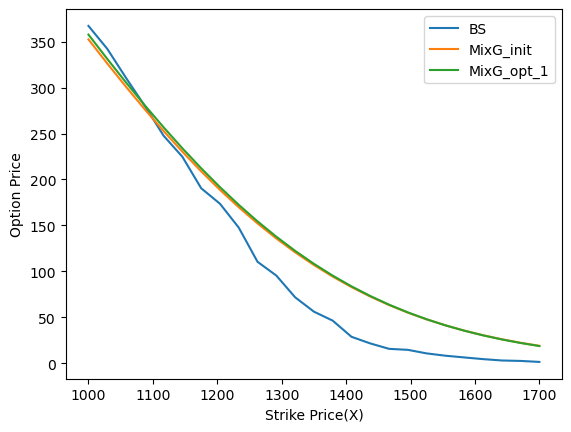

In [9]:
C_pred_opt_1 = C_MixG(X, r, tau, sigma_0, mu, pi_optimized)
print("Loss: ", loss(C_pred, C_obs))
print("Loss: ", loss(C_pred_opt_1, C_obs))

print("Expection: ", Expection(mu, pi_optimized))
print("Future Value: ", FV)

# Expection:  1346.0498046161208
# Future Value:  1352.2210030640301

# 绘制图像BS和混合模型的对比
plt.plot(X, C_obs, label='BS')
plt.plot(X, C_pred, label='MixG_init')
plt.plot(X, C_pred_opt_1, label='MixG_opt_1')
plt.xlabel('Strike Price(X)')
plt.ylabel('Option Price')
plt.legend()
plt.show()

使用Newton Ralphson Iterations优化损失函数